In [2]:
"""Jupyter Notebook for relaxation time analysis"""
#The main analysis parts adapted from script by  H. Antila, with help from S. Ollila and T. Ferreira
#saved in relaxation_times.py
# Last modified by R. Nencini, 19.10.2021

import sys
import numpy as np
from scipy import optimize
import relaxation_times as rt
import matplotlib.pyplot as plt
import os
#from numba import jit #

#gyromagnetic ratios for further developmant
# !!! NOTICE!!!
#values taken from matlab code and projecct work and slightly different than those in Wikipedia
#these values are also in the external file --> if change is needed; has to be changed there
#values here in jupyter just for the information and verify, why they are different
#!!! NOTICE END !!!
gammaD=41.695*10**6; #r*s^(-1)*T^(-1)
gammaH=267.513*10**6;
gammaC=67.262*10**6;
gammaN=-27.166*10**6;

In [1]:
"""Parameters to be specified by the user"""
OP=0 # order parameter
smallest_corr_time=0 # enter in log scale -3 fs; 0 ps; 3 ns; 6 us;
biggest_corr_time=3 # same as above
N_exp_to_fit=100 # number of exponential functions to be fitted between the samlles and biggest corr time
analyze=1/10 # the proportin of correlation data to be used for fitting, ex. 1/2 uses first half of the data
magnetic_field=2.35 # 5.99 # 8.49 T (values used in SDS paper, J.Chem. Soc.,, Faraday Trans. 1, 1988, 84(12), 4475-4486)
nuclei="2H" #nuclei to calculate: 2H-deutherium; 13C - carbon; 15N - nitrogen 

##############3
## CHANGE IN THE CODE 6.4.2022, not going throught the whole content of the folder anymore
###############
take_all_in_folder="number" #"yes"/"no"/"number" analyze all in folder? useful for proteins, if no, fill the following line, if yes fill the folder path
input_corr_file="alphaCF.xvg"
residues=24 # number of AA in a peptine, for take_all_in_folder="number"
input_prefix="" # mostly for peptides, works with take_all_in_folder="no"
folder_path="cor_times/"
output_name="SDS_micelle.out"
author_name="Ricky Nencini"

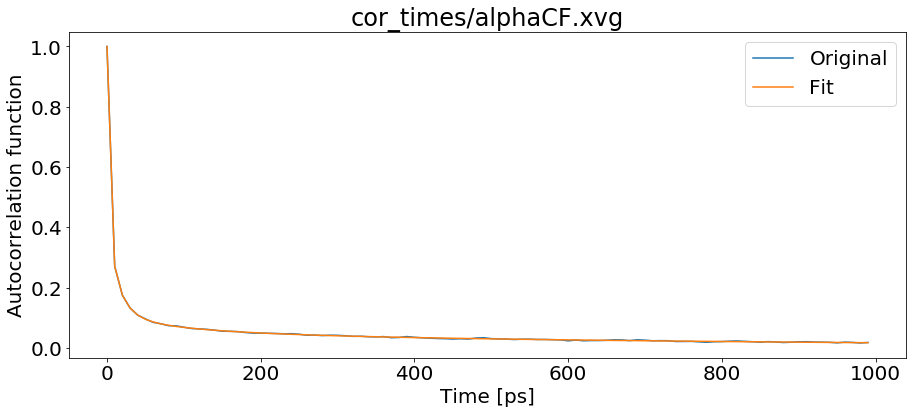

R1: 24.044672506279593 R2: 24.37502066220437 NOE: 0


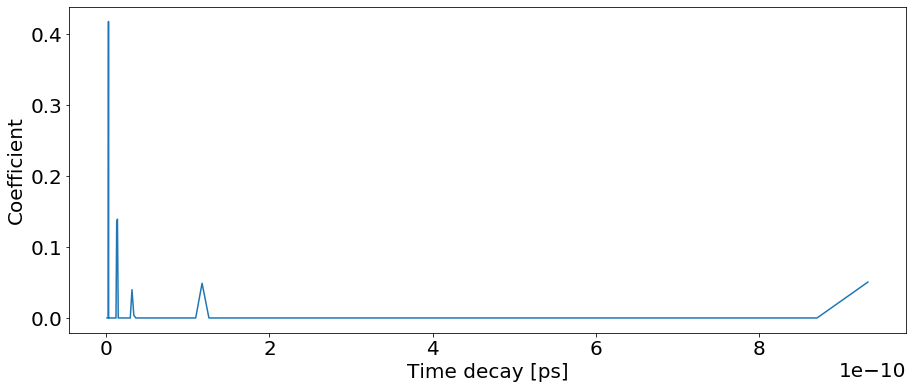

In [13]:
"""Execute the code - this part needs not be modified"""
rt.initilize_output(OP,smallest_corr_time, biggest_corr_time, N_exp_to_fit,analyze,magnetic_field,input_corr_file,nuclei,output_name,author_name)
if take_all_in_folder=="yes":
    for file in os.listdir(folder_path):
        input_corr_file = folder_path+os.fsdecode(file)
        rt.GetRelaxationData(OP,smallest_corr_time, biggest_corr_time, N_exp_to_fit,analyze,magnetic_field,input_corr_file,nuclei,output_name)
elif take_all_in_folder=="yes":
    for i in range(0,residues+1):
        input_corr_file = folder_path+input_prefix+"_"+i+".xvg"
        rt.GetRelaxationData(OP,smallest_corr_time, biggest_corr_time, N_exp_to_fit,analyze,magnetic_field,input_corr_file,nuclei,output_name)
    
else:
    rt.GetRelaxationData(OP,smallest_corr_time, biggest_corr_time, N_exp_to_fit,analyze,magnetic_field,input_corr_file,nuclei,output_name)

In [2]:
sys.path

['/home/ricky/Documents/from_work/NMR_FF_tools/relaxation_times',
 '',
 '/home/ricky/programs/amber18/lib/python2.7/site-packages',
 '/home/ricky/programs/amber18/lib/python2.7/site-packages/ParmEd-3.2.0-py2.7-linux-x86_64.egg',
 '/home/ricky/programs/amber18/lib/python2.7/site-packages/pytraj-2.0.5-py2.7-linux-x86_64.egg',
 '/home/ricky/programs/amber18/lib/python2.7/site-packages/pdb4amber-1.7.dev0-py2.7.egg',
 '/home/ricky/anaconda3/lib/python37.zip',
 '/home/ricky/anaconda3/lib/python3.7',
 '/home/ricky/anaconda3/lib/python3.7/lib-dynload',
 '/home/ricky/anaconda3/lib/python3.7/site-packages',
 '/home/ricky/anaconda3/lib/python3.7/site-packages/IPython/extensions',
 '/home/ricky/.ipython']

In [2]:
sys.path

['',
 '/home/ricky/programs/amber18/lib/python2.7/site-packages',
 '/home/ricky/programs/amber18/lib/python2.7/site-packages/ParmEd-3.2.0-py2.7-linux-x86_64.egg',
 '/home/ricky/programs/amber18/lib/python2.7/site-packages/pytraj-2.0.5-py2.7-linux-x86_64.egg',
 '/home/ricky/programs/amber18/lib/python2.7/site-packages/pdb4amber-1.7.dev0-py2.7.egg',
 '/home/ricky/anaconda3/envs/all3/lib/python36.zip',
 '/home/ricky/anaconda3/envs/all3/lib/python3.6',
 '/home/ricky/anaconda3/envs/all3/lib/python3.6/lib-dynload',
 '/home/ricky/anaconda3/envs/all3/lib/python3.6/site-packages',
 '/home/ricky/anaconda3/envs/all3/lib/python3.6/site-packages/IPython/extensions',
 '/home/ricky/.ipython']